<a href="https://colab.research.google.com/github/mgozon/DLG-UROP/blob/main/Batch_DLG_Evolution_Iris_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch-DLG Evolution - Iris Dataset
This notebook is based on the [Batch-DLG Iris Dataset](https://github.com/mgozon/DLG-UROP/blob/main/Batch_DLG_Iris_Dataset.ipynb), which implements the procedure in [Deep Leakage from Gradients](https://gist.github.com/Lyken17/91b81526a8245a028d4f85ccc9191884) on the Iris Dataset. In particular, a fully connected nueral network is trained using mini-batch gradients which are leaked.

# Setting up Libaries and Utilities

In [1]:
# setting up machine learning/visualization libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
#torch.manual_seed(100) # for generating the same random weights
from torch.utils.data import RandomSampler
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler

# setting up optimal device
print(torch.__version__)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

1.13.1+cu116
Running on cpu


In [4]:
#@title Adding dlg_stats and dlg_models
from google.colab import drive
drive.mount('/content/drive/')
%run 'drive/MyDrive/UROP/Project Files/dlg_models.ipynb'
drive.flush_and_unmount()

Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
defined: assign_guess(guess, gt_dataset, n, verbose = False): guess_perm
defined: assign_best(guess, gt_dataset, n, verbose = False): best_match
defined: compute_stats(guess_perm, gt_data, recovered_threshold = 0.25): rel_errors, recovered_rate, cos_angles
defined: batch_DLG_Adam(net, criterion, device, original_dy_dx, batch_size, gt_data_len, gt_onehot_label_len, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.001, verbose = False): dummy_data, losses
defined: label_to_onehot(target, n_classes): onehot_target
defined: train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size = 32, epochs = 100): losses
defined: test_net(net, test_data, test_target): prints accuracy
defined: train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size = 32, epochs = 100, verbo

# Preprocess Iris Dataset

In [5]:
# preprocess Iris Dataset for training
from sklearn.datasets import load_iris
dst = load_iris()
dst_length = dst.data.shape[0]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dst.data)

train_indices, test_indices = random_split(range(dst_length), [int(dst_length*4/5), int(dst_length*1/5)])
train_indices = train_indices.indices
test_indices = test_indices.indices
train_data = scaled_data[train_indices]; train_target = dst.target[train_indices]
test_data = scaled_data[test_indices]; test_target = dst.target[test_indices]

# require inputs/outputs to be 2D for uniformity
train_target = np.expand_dims(train_target, axis=1)
test_target = np.expand_dims(test_target, axis=1)

# reference variables for code
input_dim = 4
output_dim = 3

# Setting up Fully Connected Neural Network

In [6]:
# ***not equivalent to nn.CrossEntropyLoss(), which combines both nn.LogSoftmax() and nn.NLLLoss()
def cross_entropy_for_onehot(pred, onehot_target):
   return torch.mean(torch.sum(- onehot_target * torch.log(pred), 1))

In [7]:
# a fully connected neural network with random weights and biases
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Linear(input_dim, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, output_dim),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        out = self.body(x)
        return out

def weights_init(m):
    if hasattr(m, "weight"):
        nn.init.xavier_normal_(m.weight.data)
    if hasattr(m, "bias"):
        nn.init.normal_(m.bias.data)

# instantiation
net = FcNet().to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

# Train Model Normally

score: 27/30


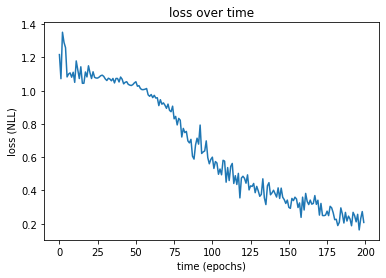

In [8]:
# note that parameters batch_size and epochs are tuned to yield a more accurate model
net.apply(weights_init)
batch_size = 32 # this affects the smoothness of the loss graph
epochs = 200
losses = train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size, epochs)
test_net(net, test_data, test_target)

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.show()

# Testing Single Batch DLG

In [10]:
# process specific batch gradient of flowers
def batch_grad(flower_indices):
    n = len(flower_indices)
    # flower_indices = torch.tensor(flower_indices)

    gt_data = torch.tensor(dst.data[flower_indices]).to(device)
    gt_label = torch.tensor(dst.target[flower_indices]).to(device); gt_label = torch.unsqueeze(gt_label, dim=1)
    gt_onehot_label = label_to_onehot(gt_label, n_classes=output_dim)

    out = net(gt_data.float())
    loss = criterion(out, gt_onehot_label)
    batch_dy_dx = torch.autograd.grad(loss, net.parameters())
    original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients
    
    return original_dy_dx, gt_data, gt_label

[117, 143, 7, 44, 149, 72, 51, 146, 49, 122, 107, 139, 119, 80, 111, 54]


  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.7000, 3.8000, 6.7000, 2.2000], dtype=torch.float64) tensor([7.4751, 3.3349, 6.2798, 2.1893], grad_fn=<SelectBackward0>) RE (AE / TN):  0.0599453508498275
tensor([6.8000, 3.2000, 5.9000, 2.3000], dtype=torch.float64) tensor([6.8891, 3.6305, 5.9689, 2.0675], grad_fn=<SelectBackward0>) RE (AE / TN):  0.05109023313695406
tensor([5.0000, 3.4000, 1.5000, 0.2000], dtype=torch.float64) tensor([6.0163, 1.5577, 4.3542, 3.5206], grad_fn=<SelectBackward0>) RE (AE / TN):  0.7793969330616535
tensor([5.1000, 3.8000, 1.9000, 0.4000], dtype=torch.float64) tensor([8.0286, 3.4432, 1.9641, 7.9948], grad_fn=<SelectBackward0>) RE (AE / TN):  1.2252878473986821
tensor([5.9000, 3.0000, 5.1000, 1.8000], dtype=torch.float64) tensor([6.3888, 3.2922, 5.6639, 1.7632], grad_fn=<SelectBackward0>) RE (AE / TN):  0.09386511277501497
tensor([6.3000, 2.5000, 4.9000, 1.5000], dtype=torch.float64) tensor([6.8149, 2.7578, 5.6682, 1.5642], grad_fn=<SelectBackward0>) 

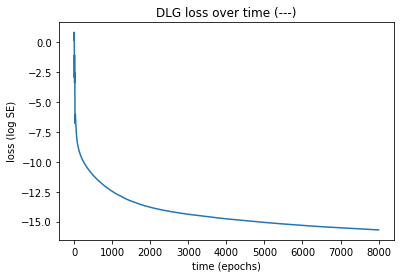

In [11]:
# testing batch-DLG with Adam
net.apply(weights_init) # see how much easier it is to attack
batch_size = 16
flower_indices = list(RandomSampler(range(dst.data.shape[0]), num_samples=batch_size))
print(flower_indices)
batch_dy_dx, gt_data, gt_label = batch_grad(flower_indices)

dummy_data, losses = batch_DLG_Adam(net, criterion, device, batch_dy_dx, batch_size, gt_data_len = input_dim, gt_onehot_label_len = output_dim, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.01, verbose = False)
guess_perm = assign_guess(dummy_data, gt_data, batch_size, verbose = True)       # assign all
assign_best(dummy_data, gt_data, batch_size, verbose = True)                     # closest match

plt.plot(torch.log(torch.tensor(losses)))
plt.title('DLG loss over time (---)')
plt.xlabel('time (epochs)')
plt.ylabel('loss (log SE)')
plt.savefig('dlg8-.png', dpi=300)

# DLG Evolution

In [9]:
# results of training a model + dlg
net.apply(weights_init)
epochs = 25
batch_size = 16
dlg_rate = 5
verbose = True
losses, dlg_timestamps, AA_REs, AA_RRate, AA_cos_angles, CA_REs, CA_RRate, CA_cos_angles, grad_norms \
    = train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size, epochs, verbose, dlg_rate, \
                         gt_data_len = input_dim, gt_onehot_label_len = output_dim, epoch_mult=500, w_decay=1e-12, scheduler_k = 0.01, leak_no_train = False)
test_net(net, test_data, test_target)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.8000, 3.0000, 1.4000, 0.3000], dtype=torch.float64) tensor([4.0109, 2.8463, 0.2043, 1.1159]) RE (AE / TN):  0.2835977049438563
tensor([5.4000, 3.0000, 4.5000, 1.5000], dtype=torch.float64) tensor([4.2192, 2.5998, 1.2845, 1.9440]) RE (AE / TN):  0.4464655481600607
tensor([6.1000, 2.6000, 5.6000, 1.4000], dtype=torch.float64) tensor([6.1047, 2.9253, 7.3568, 1.9306]) RE (AE / TN):  0.21200443766121901
tensor([5.8000, 2.7000, 3.9000, 1.2000], dtype=torch.float64) tensor([6.1317, 1.6038, 1.2374, 0.6623]) RE (AE / TN):  0.3884857414491217
tensor([5.4000, 3.4000, 1.7000, 0.2000], dtype=torch.float64) tensor([5.7796, 1.5667, 0.3952, 0.6109]) RE (AE / TN):  0.3509540115484326
tensor([4.7000, 3.2000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 4.9269,  3.6136,  1.8036, -0.0667]) RE (AE / TN):  0.09795086800734587
tensor([4.9000, 3.0000, 1.4000, 0.2000], dtype=torch.float64) tensor([5.0290, 3.2898, 0.6341, 0.0790]) RE (AE / TN):  0.1415

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.7000, 3.3000, 5.7000, 2.1000], dtype=torch.float64) tensor([  3.1430,   0.2974, -17.7004,  -3.2973]) RE (AE / TN):  2.5409398652459685
tensor([5.4000, 3.4000, 1.5000, 0.4000], dtype=torch.float64) tensor([ 3.2432,  2.6296, -5.4149, -1.6154]) RE (AE / TN):  1.150833745682171
tensor([5.4000, 3.9000, 1.7000, 0.4000], dtype=torch.float64) tensor([  1.2780,   5.4598, -10.4766,  -3.9827]) RE (AE / TN):  1.985295040459153
tensor([6.0000, 3.0000, 4.8000, 1.8000], dtype=torch.float64) tensor([7.8387, 3.0476, 8.7697, 3.7727]) RE (AE / TN):  0.5684518944936474
tensor([6.8000, 3.2000, 5.9000, 2.3000], dtype=torch.float64) tensor([  2.7603,   0.2746, -19.4057,  -3.8177]) RE (AE / TN):  2.6973446898032707
tensor([4.7000, 3.2000, 1.6000, 0.2000], dtype=torch.float64) tensor([ 3.8735,  4.4009, -0.4891, -0.8190]) RE (AE / TN):  0.4642388565328072
tensor([5.3000, 3.7000, 1.5000, 0.2000], dtype=torch.float64) tensor([  2.5634,   2.6330, -10.7938, 

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.7000, 3.1000, 4.4000, 1.4000], dtype=torch.float64) tensor([8.9462, 3.0641, 6.9769, 3.8352]) RE (AE / TN):  0.4820347727071059
tensor([6.8000, 3.2000, 5.9000, 2.3000], dtype=torch.float64) tensor([8.2286, 2.8670, 9.1016, 3.0874]) RE (AE / TN):  0.3671933902945972
tensor([7.7000, 2.8000, 6.7000, 2.0000], dtype=torch.float64) tensor([13.3215,  1.4081, 13.0796,  8.9314]) RE (AE / TN):  1.0266300248125886
tensor([6.3000, 3.3000, 6.0000, 2.5000], dtype=torch.float64) tensor([8.2051, 2.9106, 9.0815, 3.1134]) RE (AE / TN):  0.38350933367905
tensor([6.0000, 2.9000, 4.5000, 1.5000], dtype=torch.float64) tensor([6.3878, 2.7055, 5.0976, 1.5502]) RE (AE / TN):  0.0904918464987995
tensor([7.3000, 2.9000, 6.3000, 1.8000], dtype=torch.float64) tensor([13.1002,  1.3529, 12.0642,  8.7114]) RE (AE / TN):  1.057593593464961
tensor([5.7000, 2.6000, 3.5000, 1.0000], dtype=torch.float64) tensor([6.0499, 2.5793, 4.2705, 1.3682]) RE (AE / TN):  0.12740

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.7000, 3.0000, 6.1000, 2.3000], dtype=torch.float64) tensor([10.0006,  0.7032, 14.1086, 10.0353]) RE (AE / TN):  1.1019838483138236
tensor([5.4000, 3.9000, 1.3000, 0.4000], dtype=torch.float64) tensor([ 4.6010,  3.5237,  0.5099, -0.1458]) RE (AE / TN):  0.19190187385028915
tensor([5.0000, 2.0000, 3.5000, 1.0000], dtype=torch.float64) tensor([5.3675, 1.8461, 3.8835, 1.2762]) RE (AE / TN):  0.09508813794554685
tensor([6.5000, 2.8000, 4.6000, 1.5000], dtype=torch.float64) tensor([ 9.2586,  2.9055, 10.1687,  4.5158]) RE (AE / TN):  0.8058154827905842
tensor([4.8000, 3.4000, 1.9000, 0.2000], dtype=torch.float64) tensor([5.1821, 2.9210, 4.7259, 0.6922]) RE (AE / TN):  0.47425791843863485
tensor([6.0000, 3.4000, 4.5000, 1.6000], dtype=torch.float64) tensor([7.4819, 2.6470, 6.9677, 3.5791]) RE (AE / TN):  0.4259773209904912
tensor([5.1000, 3.5000, 1.4000, 0.2000], dtype=torch.float64) tensor([ 4.4897,  3.4129,  0.5865, -0.2307]) RE (AE /

  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.1000, 3.0000, 4.6000, 1.4000], dtype=torch.float64) tensor([ 8.2578,  3.1917, 12.4553,  5.0227]) RE (AE / TN):  1.0709868871431687
tensor([4.8000, 3.0000, 1.4000, 0.3000], dtype=torch.float64) tensor([5.8794, 2.3745, 3.6314, 0.9327]) RE (AE / TN):  0.45105396578179385
tensor([5.6000, 2.7000, 4.2000, 1.3000], dtype=torch.float64) tensor([5.6052, 2.5657, 4.9474, 1.0524]) RE (AE / TN):  0.10489512968290374
tensor([6.3000, 2.9000, 5.6000, 1.8000], dtype=torch.float64) tensor([ 7.5826,  1.5645, 25.5069,  7.9130]) RE (AE / TN):  2.2989476415045575
tensor([5.7000, 2.6000, 3.5000, 1.0000], dtype=torch.float64) tensor([6.0582, 2.2539, 4.0339, 1.2479]) RE (AE / TN):  0.10641762961337595
tensor([6.3000, 2.3000, 4.4000, 1.3000], dtype=torch.float64) tensor([5.9124, 2.5642, 4.2589, 1.5719]) RE (AE / TN):  0.0689421690816609
tensor([6.3000, 2.5000, 5.0000, 1.9000], dtype=torch.float64) tensor([10.5835,  2.5179, 20.6757,  9.0987]) RE (AE / TN)

In [10]:
# save python results for future reference
import pickle
save_file = 'train_dlg_16_big.p'
path = 'drive/MyDrive/UROP/Project Files/'
drive_file = path + save_file
print(save_file, drive_file)

from google.colab import drive
pickle.dump((epochs, losses, dlg_timestamps, AA_REs, AA_RRate, AA_cos_angles, CA_REs, CA_RRate, CA_cos_angles, grad_norms), open(save_file, "wb"))
drive.mount('/content/drive/')
!cp "$save_file" "$drive_file"  # need double quotations since path has a space
drive.flush_and_unmount()

train_dlg_16_big.p drive/MyDrive/UROP/Project Files/train_dlg_16_big.p
Mounted at /content/drive/


In [2]:
# load python results
import pickle
save_file = 'train_dlg_16_big.p'
path = 'drive/MyDrive/UROP/Project Files/'
drive_file = path + save_file

from google.colab import drive
drive.mount('/content/drive/')
!cp "$drive_file" "$save_file"  # need double quotations since path has a space
drive.flush_and_unmount()
epochs, losses, dlg_timestamps, AA_REs, AA_RRate, AA_cos_angles, CA_REs, CA_RRate, CA_cos_angles, grad_norms = pickle.load(open(save_file, "rb"))

Mounted at /content/drive/


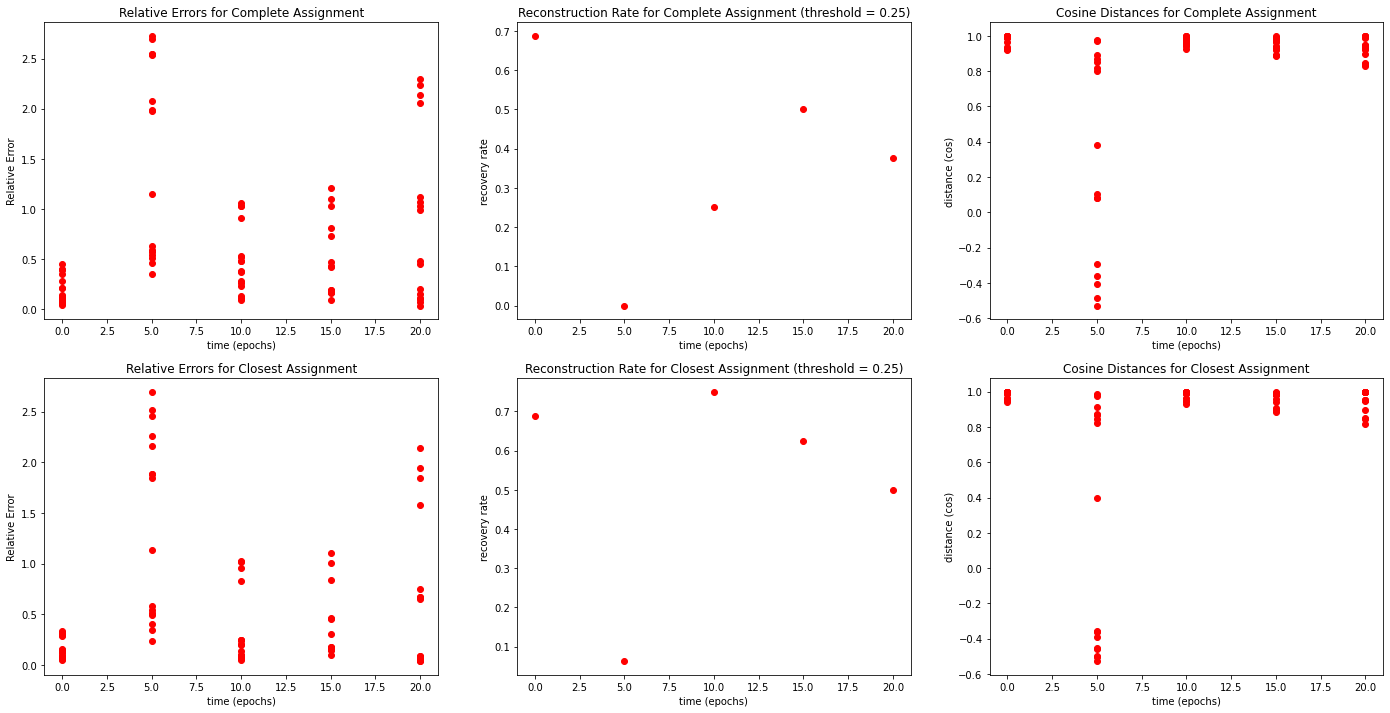

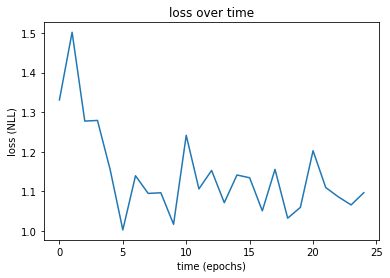

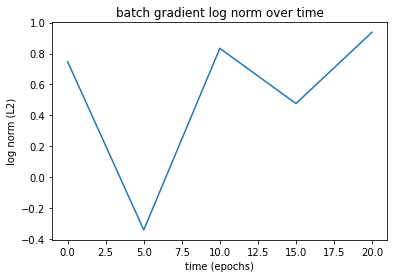

In [3]:
# create summary plots of MSE and normalized errors over time
rows = 2; cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(8*cols, 6*rows))

# complete assignment
axs[0, 0].plot(dlg_timestamps, AA_REs, 'ro')
axs[0, 0].set(title='Relative Errors for Complete Assignment', xlabel='time (epochs)', ylabel='Relative Error')

axs[0, 1].plot(dlg_timestamps, AA_RRate, 'ro')
axs[0, 1].set(title='Reconstruction Rate for Complete Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[0, 2].plot(dlg_timestamps, AA_cos_angles, 'ro')
axs[0, 2].set(title='Cosine Distances for Complete Assignment', xlabel='time (epochs)', ylabel='distance (cos)')

# closest assignment
axs[1, 0].plot(dlg_timestamps, CA_REs, 'ro')
axs[1, 0].set(title='Relative Errors for Closest Assignment', xlabel='time (epochs)', ylabel='Relative Error')

axs[1, 1].plot(dlg_timestamps, CA_RRate, 'ro')
axs[1, 1].set(title='Reconstruction Rate for Closest Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[1, 2].plot(dlg_timestamps, CA_cos_angles, 'ro')
axs[1, 2].set(title='Cosine Distances for Closest Assignment', xlabel='time (epochs)', ylabel='distance (cos)')

plt.savefig('train_DLG_16_big_errors.png', dpi=300)
plt.show()

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.savefig('train_DLG_16_big_loss.png', dpi=300)
plt.show()

plt.plot(dlg_timestamps, torch.log(torch.tensor(grad_norms)))
plt.title('batch gradient log norm over time')
plt.xlabel('time (epochs)')
plt.ylabel('log norm (L2)')
plt.savefig('train_DLG_16_big_norm.png', dpi=300)
plt.show()

In [ ]:
#@title Evolution Plots (not updated)
# evolution of SEs, normalized errors, cosine distances
fig, axs = plt.subplots(len(dlg_timestamps), 3, sharex='col', figsize=(24, len(dlg_timestamps)*4))

for i in range(len(dlg_timestamps)):
    axs[i, 0].hist(torch.log(torch.tensor(dlg_SEs[i])), 50)
    axs[i, 0].set(title=f'log SE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log SE', ylabel='frequency')

    axs[i, 1].hist(torch.log(torch.tensor(dlg_n_errors[i])), 50)
    axs[i, 1].set(title=f'log NE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log NE', ylabel='frequency')

    axs[i, 2].hist(dlg_cos_angles[i], 50)
    axs[i, 2].set(title=f'cosine distances of batch DLG at epoch {dlg_timestamps[i]}', xlabel='cosine distance', ylabel='frequency')

# Notes

In [ ]:
# Todo

# *consider using pickle to save variables e.g. DLG results (for changing labels of graphs / postprocessing)

# future tasks -----------------------------------------------------------
# also add comments to functions abstracted out into a package
# look at dp
# look at papers more related to FL
# estimate how quickly the model can be trained + attacked
# icml workshop for results
# consider other medical dataset
# possible idea - PCA with image tasks to capture similarity between reconstructed and true input data
# consider dropout with a probability like ~ 0.20-0.25 (or even, aggressively, 0.5 - good for generalization)